# Overview
This is my attempt to solve the first assignment of the Introduction to Machine Learning course, fall 2022.
## Note
Please make sure the dataset is saved in the same working directory as this notebook.
  
Please note that further in this notebook I will use the term ***f $i$*** to refer to the column ***var $i$***

Please when reading the theoretical part, refer to the theory-related part for the coding arguments I made in my report.

# Preliminary: imports and Loading data

In [1]:
# main imports needed for the rest of the notebook
import os
import math
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
# setting seaborn to darkgrid for a more detailed display of the values
STYLE = 'darkgrid'
sns.set_style(STYLE)

RANDOM_STATE = 11

import warnings
warnings.filterwarnings('ignore')

In [2]:
wd = os.getcwd()
dataset_name = "a1_dataset.csv"
file_path = os.path.join(wd, dataset_name) # setting the location of the file 

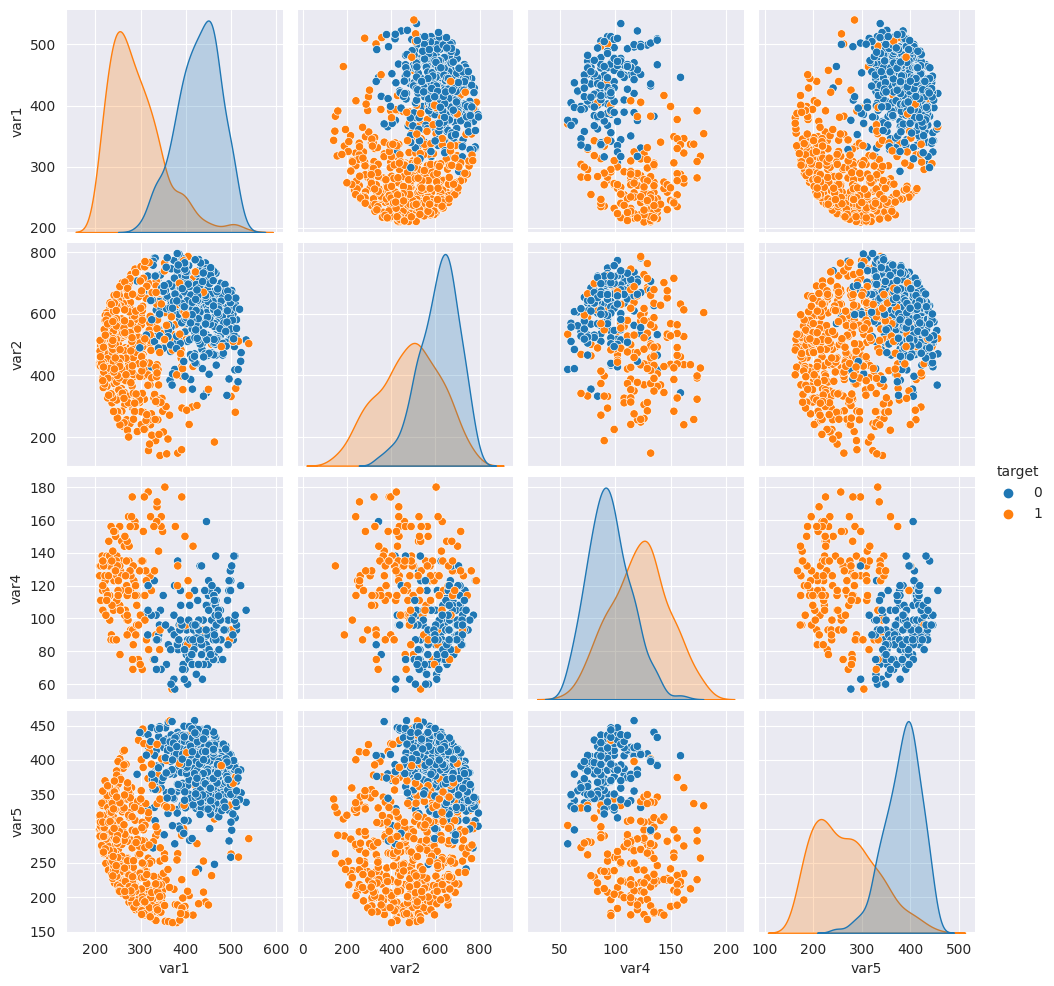

In [3]:
df_org = pd.read_csv(file_path) # save original datafrae 
df = df_org.copy() # copy to work on
sns.pairplot(df, hue='target')


In [91]:
# let's rename the columns
new_names = {"target": "y"}
y = df['target']
for i in range(1, len(df.columns) + 1):
    new_names[f'var{str(i)}'] = f"f{str(i)}"
df = df.rename(columns=new_names)
print(df.columns)
# I will drop the target column and add it to the dataframe when needed
df.drop('y', inplace=True, axis=1)

Index(['y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], dtype='object')


# Preprocessing
In this part I preprocess the data for the training phase:
* distinguish between numerical and categorial data
* clean certain columns
* encode categorical features
* impute missing vaues

## Cleaning data
Let's start cleaning by fixing the 'var7' column.

In [92]:
# this method returns a tuple of the column names : numerical then categorical
def num_cat(df):
    num = df.select_dtypes(np.number).columns.values
    cat = df.select_dtypes(['object', 'category']).columns.values
    return num, cat

num_cols, cat_cols = num_cat(df)

In [93]:
# let's set the last column to datetime for further manipulation
try:    
    df['f7'] = pd.to_datetime(df['f7']) 
except:
    print("Certain dates are semantically invalid")
    
from dateutil import parser

# for futher manipulation we need to determine the invalid dates
def validate_dates(row):
    format_date = "%Y-%m-%-d %H:%M:%S"
    try:
        row['valid_date'] = parser.parse(row['f7']) # if the data isinvalid an error will raise, 
    except ValueError:
        row['valid_date'] = False # the except block will catch it and set the field to False
    return row

df = df.apply(validate_dates, axis=1)
invalid_dates = df[df['valid_date'] == False]['f7'].values
# drop the additional column
df.drop('valid_date', axis=1, inplace=True)

Certain dates are semantically invalid


In [94]:
print(invalid_dates) # this is the list of invalid dates in the dataframes
# let's reduce these dates by 24 hours

def fix_dates(row):
    if row['f7'] in invalid_dates:
        date, time = row['f7'].split()
        # change the 29 to 28
        date = date[:-2] + "28"
        row['f7'] = date + " " + time
    return row

df = df.apply(fix_dates, axis=1)

df['f7'] = pd.to_datetime(df['f7'])

['2019-02-29 12:31:57' '2019-02-29 18:06:21' '2019-02-29 11:00:06'
 '2019-02-29 23:56:06' '2019-02-29 19:26:35']


In [95]:
print(df.dtypes)
# now that the 7th column is converted to datetime, we can futher break it down and tackle each component of the date: year, month, day, time
year = 'year'
month = 'month'
day = 'day'
time = 'time'
date_cols = [year, month, day, time]
def decompose_date(row):
    row[year] = row['f7'].year
    row[month] = row['f7'].month
    row[day] = row['f7'].day
    row[time] = row['f7'].time
    return row

df = df.apply(decompose_date, axis=1)

f1           float64
f2           float64
f3            object
f4           float64
f5           float64
f6            object
f7    datetime64[ns]
dtype: object


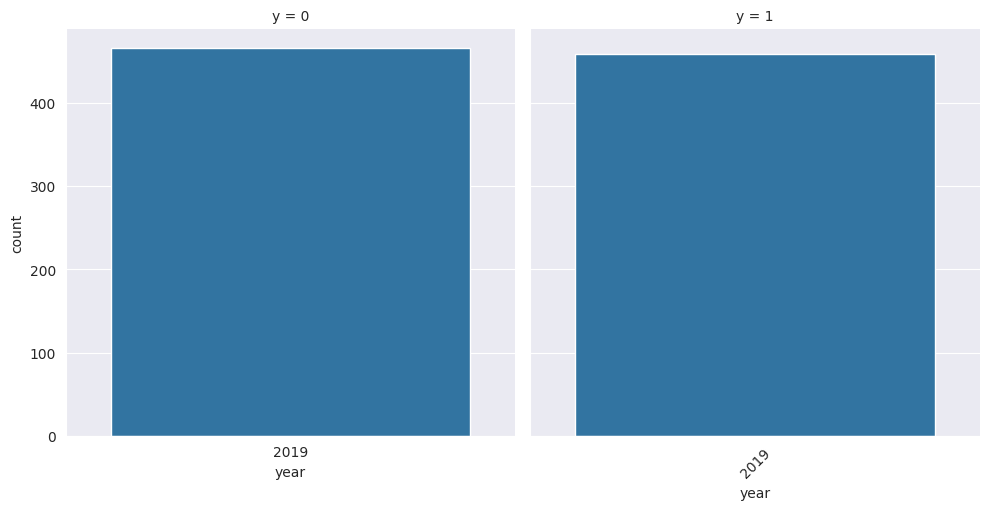

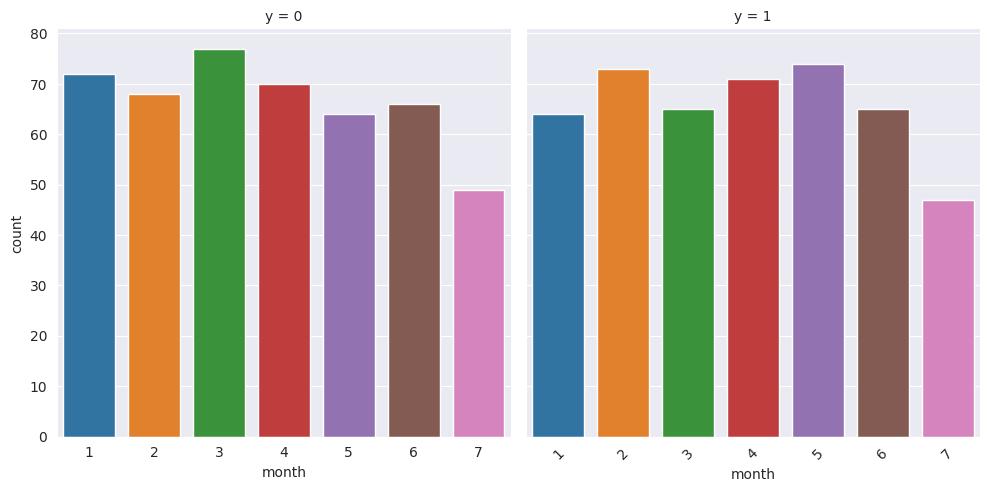

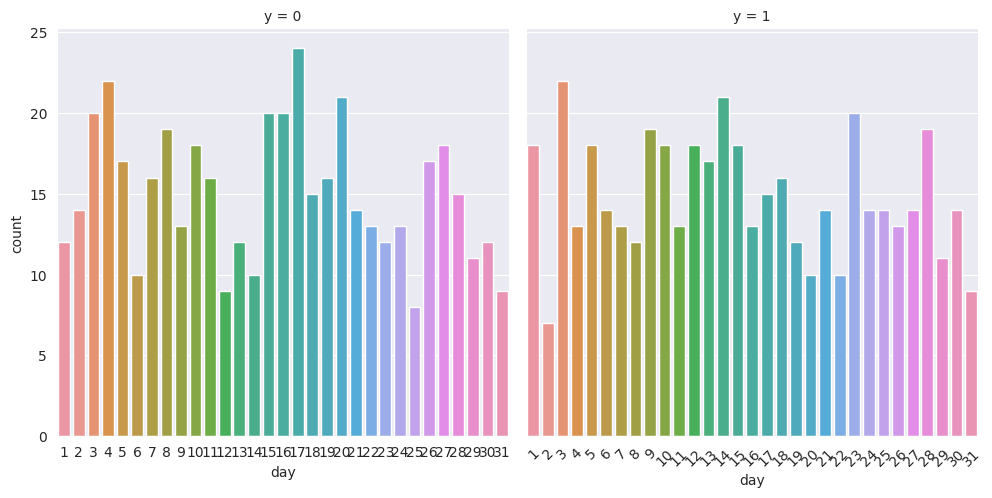

In [96]:
for c in date_cols[:-1]: # the time column has a significantly large number of unique values.
    df_c = df.copy()
    df_c['y'] = y
    fig = sns.catplot(data=df_c, kind='count', x=c, col='y', col_order=[0, 1])
    fig.set(xlabel=c, ylabel='count')
    plt.xticks(rotation=45)
    plt.show()

These are my observations:
* there is only one year present in all dates: 2019. The year can be dropped then
* The dataset is clearly not a time-series dataset where each second, minute or even hour is important, so the time part can be dropped as well

There are two main options left:
1. keep the date as month + day.
2. reduce the date to the month value.

In [97]:
f7_drop = ['f7', 'time', 'year']
for t in f7_drop:
    df.drop(t, axis=1, inplace=True)

In [98]:
# let's investigate the first option: keep the date as day and month 
def set_date(row):
    row['date'] = pd.Timestamp(year=2019, month=row[month], day=row[day])
    return row

df = df.apply(set_date, axis=1) 


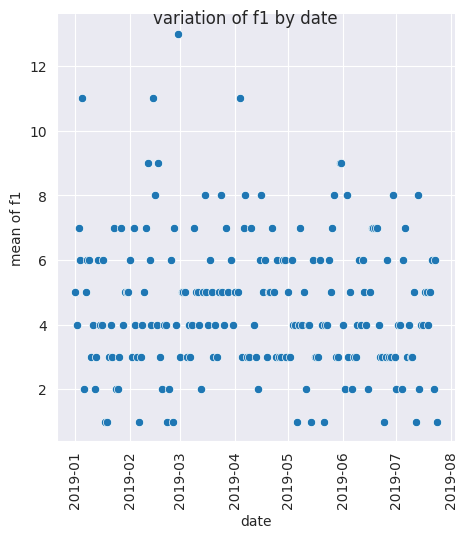

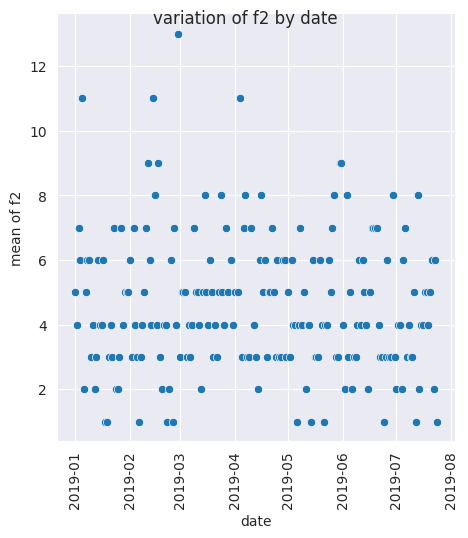

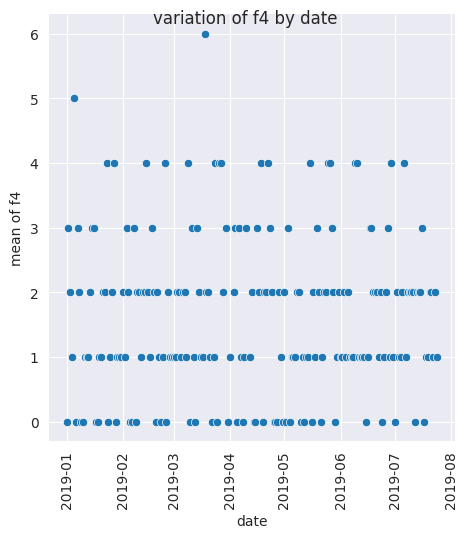

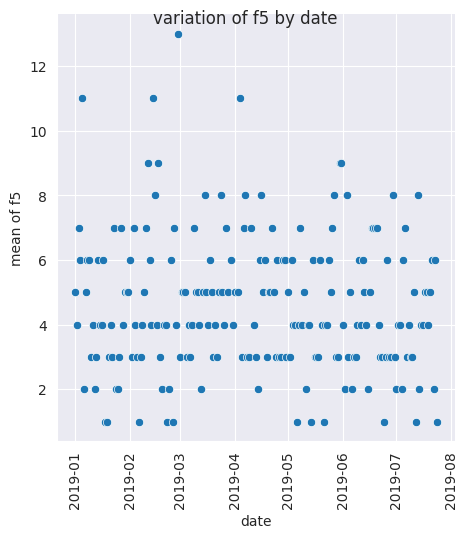

In [99]:
# time to consider the different interactions between the date and the rest of the columns
num_cols, cat_cols = num_cat(df)

for col in num_cols[:-2]:
    col_by_date = pd.pivot_table(df.sort_values(by='date', ascending=True), index='date', values=col, aggfunc=['count', 'mean', 'median'])
    g = sns.relplot(kind='scatter', x=col_by_date.index.values, y=col_by_date[('count', col)].values)
    g.fig.suptitle(f"variation of {col} by date")
    g.set(xlabel='date', ylabel=f'mean of {col}')
    plt.xticks(rotation = 90)
    plt.show()

In [100]:
# it might be more efficient to consider the day of the year
def set_day_of_year(row):
    date = pd.Timestamp(year=2019, month=row[month], day=row[day])
    row['day_of_year'] = (date - pd.Timestamp(year=2019, month=1, day=1)).days + 1
    return row

df = df.apply(set_day_of_year, axis=1)

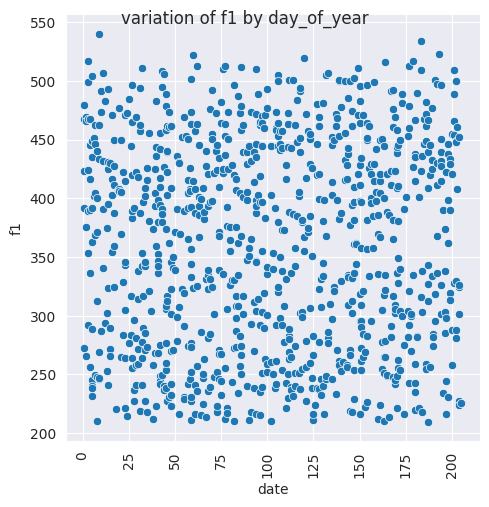

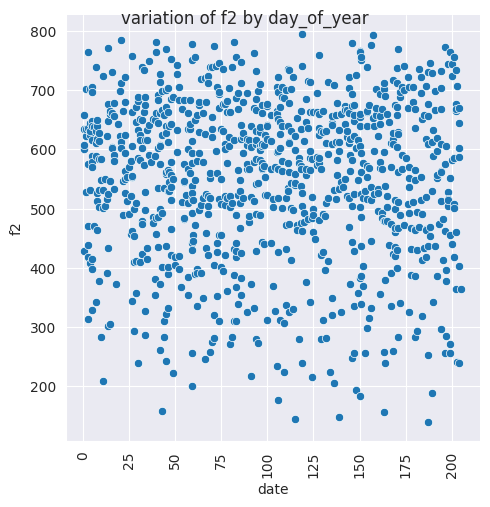

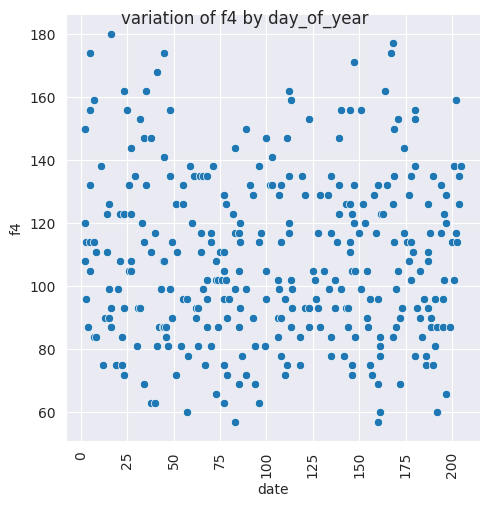

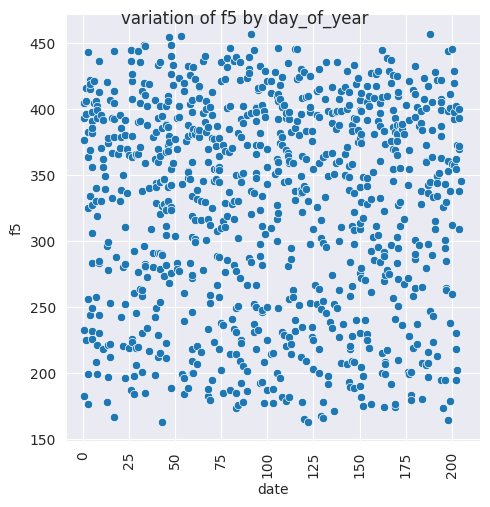

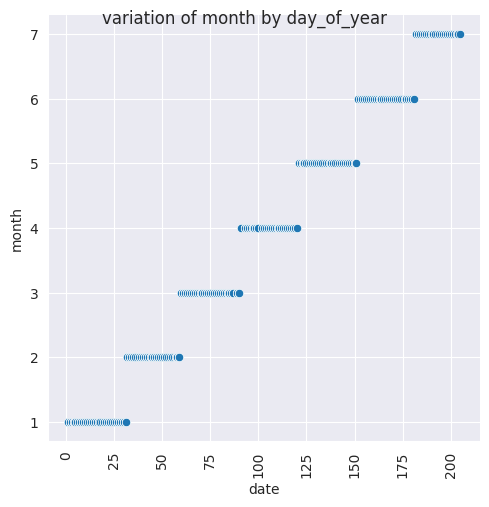

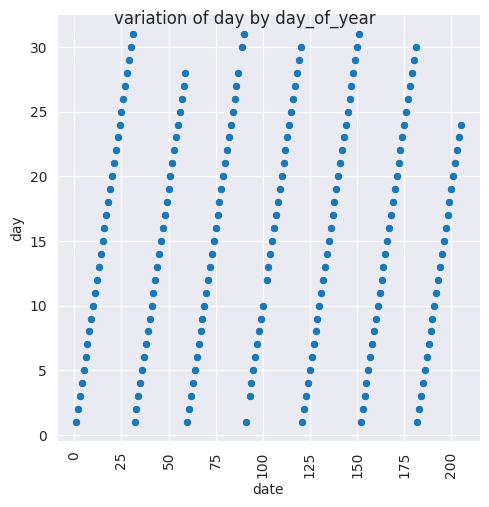

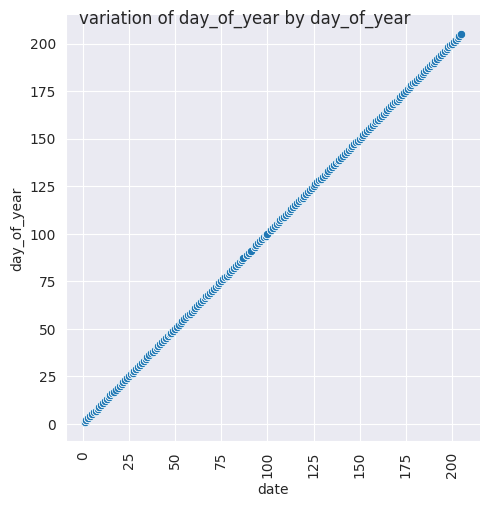

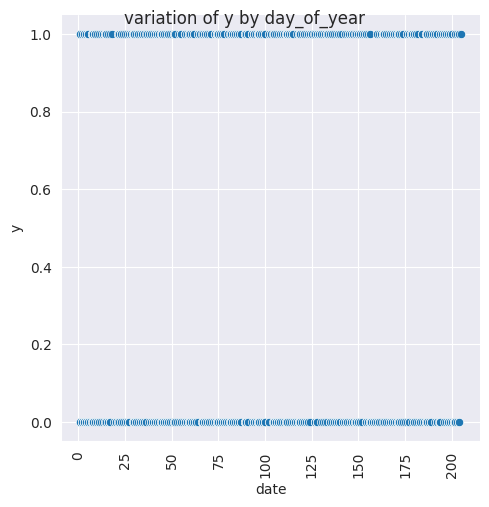

In [101]:
df['y'] = y.copy()
num_cols, cat_cols = num_cat(df)

for col in num_cols:
    g = sns.relplot(data=df.sort_values(by='date', ascending=True), x='day_of_year', y=col)
    g.fig.suptitle(f"variation of {col} by day_of_year")
    g.set(xlabel='date', ylabel=f'{col}')
    plt.xticks(rotation = 90)
    plt.show()
df.drop('y', axis=1, inplace=True)

In [102]:
# the visualizations do not show any trend in the interacation between day_of_year and any other numerical feature or the target variable
# let's confirm that by calculating the correlation
df['y'] = y.copy()
print(df.corr()['day_of_year'])
df.drop('y', axis=1, inplace=True)
# as we can see the correlation is below 0.02

f1             0.015491
f2            -0.050410
f4            -0.009622
f5            -0.019079
month          0.988924
day            0.131636
day_of_year    1.000000
y              0.016102
Name: day_of_year, dtype: float64


Given the provided evidence it is safe to assume that the first option might not  be suitable for our data. I will use the second option: encoding the data column as its month value.

In [103]:
day_cols = ['day', 'day_of_year', 'date']
for d in day_cols: df.drop(d, axis=1, inplace=True)
df_bef_enc = df.copy() # save the data before encoding f3

## Encoding Categorical variables
It is imperative to convert the categorical variables to numerical representations before feeding them to machine learning models
### Encoding f6
Ordinal Encoder is a perfect encoding technique for f6 as the values "yes" and "no" can be ordered. The order of the numerical representations does not matter as the machine learning algorithm can assign either positive or negative signs correcting the order proposed by the encoder.

In [104]:
# let's encode f6 as no:0 and yes:1
print(df['f6'].value_counts())
# the column has only 2 values "yes" and "no" as suggested above.
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder() # default parameters: as no customized order can be deduced from the data, the ordering is left up to the encoder
X = oe.fit_transform(df[['f6']]) # create a new dataframe where the column f6 is encoded
# create the final dataframe
df = pd.concat([df.drop('f6', axis=1), pd.DataFrame(X, columns=['f6'])], axis=1)

yes    483
no     442
Name: f6, dtype: int64


### Encoding f3: the area column:
Both One Hot Encoding and Ordinal Encoding have advantages and disadvantages:
* OneHotEncoding will increase number of features significantly
* OrdinalEncoding: might impose an ordering that does not necessarily fit the data
To decide, I will divide the non-Na data into training and test data. The encoding producing a better performan will be the method of choice.


In [105]:
# first let's save a copy of the current dataframe: before the encoding, for later use.
df_bef_imp = df.copy()

In [106]:
# before proceeding with the encoding, it is recommended to clean the data by normalizing the string representation and remove any possible unwanted characetrs
def clean_country(row):
    row['f3'] = row['f3'].strip().lower()
    # remove any string between parentheses if they exist
    row['f3'] = re.sub('\(.*\)', "", row['f3'])
    # remove any string between brackets if they exist
    row['f3'] = re.sub('\[.*\]', "", row['f3'])
    return row

df = df.apply(clean_country, axis=1)

In [107]:
## ONE HOT ENCODING
df_OHE = df.copy()
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X = ohe.fit_transform(df_OHE[['f3']])
df_OHE = pd.concat([df_OHE.drop('f3', axis=1), pd.DataFrame(X, columns=ohe.get_feature_names_out())], axis=1)

In [108]:
df_OE = df.copy()
oe = OrdinalEncoder() # default parameters: as no customized order can be deduced from the data, the ordering is left up to the encoder
X = oe.fit_transform(df[['f3']]) # create a new dataframe where the column f3 is encoded
# create the final dataframe
df_OE = pd.concat([df_OE.drop('f3', axis=1), pd.DataFrame(X, columns=['f3'])], axis=1)


In [109]:
## target encoding:
df_TE = df.copy()
# first let's consider only the values where f4 is defined

df_4 = df_TE[~df_TE['f4'].isna()]
f4_by_area = pd.pivot_table(df_4, index='f3', values='f4', aggfunc=['count', 'mean'])

def encode_area(row):
    area = row['f3']
    # encode the area as the mean of f4 for that area
    if area in f4_by_area.index.values: 
        row['f3'] = f4_by_area[('mean', 'f4')][area]

    # if the area if seen for the first time: encode it as the median of f4 by corresponding month
    else:
        row['f3'] = np.median(df_4['f4'])
    return row
df_TE = df_TE.apply(encode_area, axis=1).fillna(np.median(df_TE['f4']))

#### Helper functions
In the following subsection, I create helper functions to facilate evaluating encodings without duplicating code.

In [110]:
# prepare cross validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
CV = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [111]:
from sklearn.preprocessing import StandardScaler

def scale_data(df_4, df_4_t):
    # scale the training data
    scaler = StandardScaler()
    Xs = scaler.fit_transform(df_4)
    df = pd.DataFrame(Xs, columns=df_4.columns)

    # scale the test data
    Xs = scaler.transform(df_4_t)
    df_t = pd.DataFrame(Xs, columns=df_4_t.columns)
    return df, df_t 

In [112]:
from audioop import cross
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor as knr
from sklearn.linear_model import LinearRegression 

SCORING = "neg_mean_squared_error"


def best_linear_reg(df: pd.DataFrame, y: np.array):
    """Given a train and test datasets, it will return a linear Regression model trained on the data.

    Args:
        df (pd.DataFrame): training data
        y (np.array): target values associated with the training data
    """
    global CV, SCORING
    X_train = df.values
    
    lr = LinearRegression()
    lr.fit(df.values, y)
    return lr, - np.mean(cross_val_score(lr, df.values, y, scoring=SCORING, cv=CV))

def best_ridge(df: pd.DataFrame, y:np.array ):
    """Given a training and dataset, it will return the Ridge model with the lowest mean squared error on cross validation

    Args:
        df_4 (pd.DataFrame): the training data
        y_f4 (np.array): the training target values

    Returns:
    Ridge estimator with the alpha hyperparameter tuned
    """
    global CV, SCORING
    X_train = df.values
    
    ridge = Ridge(max_iter=5000, random_state=RANDOM_STATE)
    parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

    ridge_search = GridSearchCV(ridge, parameters, cv=CV, scoring=SCORING, n_jobs=-1)

    ridge_search.fit(X_train, y)

    return ridge_search.best_estimator_, -ridge_search.best_score_

def best_lasso(df: pd.DataFrame, y: np.array):
    """Given a training and dataset, it will return the Lasso model with the lowest mean squared error on cross validation

    Args:
        df_4 (pd.DataFrame): the training data
        y_f4 (np.array): the training target values

    Returns:
    Lasso estimator with the alpha hyperparameter tuned.
    """
    global CV, SCORING 
    X_train = df.values

    lasso = Lasso(max_iter=5000, random_state=RANDOM_STATE)
    
    parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

    lasso_search = GridSearchCV(lasso, parameters, cv=CV, scoring=SCORING, n_jobs=-1)
    lasso_search.fit(X_train, y)


    return lasso_search.best_estimator_, - lasso_search.best_score_

def best_knr(df, y):
    """Given a training and dataset, it will return the KNearestNeighbors Regressor with the lowest mean squared error on cross validation

    Args:
        df_4 (pd.DataFrame): the training data
        y_f4 (np.array): the training target values

    Returns:
    KNearestNeighbors regressor with the "K" hyperparameter tuned.
    """

    X_train = df.values

    k_reg = knr() # a default model

    # there are two main parameters to tune: number of neighbors and the type of distance

    k_reg_params = {"n_neighbors": list(range(1, 15)), "weights":['uniform', 'distance']}

    k_reg_search = GridSearchCV(k_reg, k_reg_params, cv=CV, scoring=SCORING)

    k_reg_search.fit(X_train, y)

    return k_reg_search.best_estimator_, -k_reg_search.best_score_ 

In [113]:
from sklearn.preprocessing import PolynomialFeatures

def best_poly_features(df, y, max_degree=5):
    """given the training dataset and the corresponding target values, it returns the degree for which POLYNOMIAL REGRESSION 
    performs the best

    Args:
        df_4 (DataFrame): training data
        yf4 (Series): training target values
    """
    global CV
    
    X_t = df.values
    y_t = y.values

    polys = [PolynomialFeatures(degree=i) for i in range(2, max_degree + 1)]
    X_trains = [p.fit_transform(X_t) for p in polys]    
    
    # intiate a Linear Regression model

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    print("Finding the best degree for polynomial features")
    best_score = 10 ** 9
    best_deg = 0
    scoring = "neg_mean_squared_error"
    for i in range(len(X_trains)): 
        score = -np.mean(cross_val_score(lr, X_trains[i], y_t, cv=CV, scoring=SCORING))
        print()
        print(f"best mean squared error for degree {str(i + 2)}: {str(np.mean(score))}")
        print()
        if best_score > score:
            best_score = score
            best_deg = i + 2
    
    return best_score, best_deg, polys[best_deg - 2]

def best_poly_reg(df, y, max_degree=5):
    _,_, poly = best_poly_features(df, y, max_degree)
    X_train = df.values
    # apply the best polynomial features on the training data
    X_train = poly.transform(X_train)
    # find the best non-regularized Linear Regression estimator
    
    # consider non-regularized linear regression
    lr_est, lr_score = best_linear_reg(pd.DataFrame(X_train), y)
    # find the best ridge estimator with this training data
    ridge_est, ridge_score = best_ridge(pd.DataFrame(X_train), y)
    # find the best lasso estimator with this training data
    lasso_est, lasso_score = best_lasso(pd.DataFrame(X_train), y)
    
    ests = np.array([lr_est, ridge_est, lasso_est])
    scores = np.array([lr_score, ridge_score, lasso_score])
    
    min_index = np.argmin(scores)
    
    return ests[min_index], poly # return the best model as well as the associated polynomail transformation
    


In [114]:
# given a training and test dataset for prediting f4, this function will return the model that performs better the test dataset.
def best_imputation_model(df_4, df_4_t, y_f4, y_f4_t, max_poly_deg=2): 
    global CV
    df, df_t = scale_data(df_4, df_4_t)
    # we will find the best possible Ridge, Lasso, Polynomial Regularized Regression and the best KNN-R
    # each of them will be tested on the test dataset and the one with best score will be returned
    
    # the best_poly_reg will return the best model that works with polynomial features
    poly = best_poly_reg(df, y_f4, max_poly_deg)
    
    lin_reg = best_linear_reg(df, y_f4)
    ridge = best_ridge(df, y_f4)
    lasso = best_lasso(df, y_f4)
    # knn = best_knr(df, y_f4)

    X_train = df.values
    X_test = df_t.values
    models = [poly, lin_reg, ridge, lasso ] #, knn]
    

    best_score = 10 ** 9
    best_model = None
    
    # first evaluate the polynomial regression
    X_train_poly = poly[1].transform(X_train)
    X_test_poly = poly[1].transform(X_test)

    poly[0].fit(X_train_poly, y_f4) 
    y_pred = poly[0].predict(X_test_poly)
    score = (mean_squared_error(y_pred, y_f4_t))
    print()
    print(f"The model {str(poly[0])} achived a mean square error of {str(score)}")
    print()
    if score < best_score:
        best_model = poly
        best_score = score
        
    ## evaluate the rest of the models
    for m in models[1:]:
        m[0].fit(X_train, y_f4) 
        y_pred = m[0].predict(X_test)
        score = (mean_squared_error(y_pred, y_f4_t))
        print()
        print(f"The model {str(m)} achived a mean square error of {str(score)}")
        print()
        if score < best_score:
            best_model = m
            best_score = score
            
    return best_model, best_score   


##### Evaluate the encodings

In [115]:
from sklearn.model_selection import train_test_split

def divide_f4(df):
    df_f4 = df[~df['f4'].isna()]
    df_imp = df[df['f4'].isna()]
    f4 = df_f4['f4'].copy()
    df_f4.drop('f4', axis=1, inplace=True)
    df_imp.drop('f4', axis=1, inplace=True)
    
    df, df_t, y, y_t = train_test_split(df_f4, f4, test_size=0.2, random_state=RANDOM_STATE)
    return df, df_t, y, y_t, df_imp


In [116]:
# divide the data encoded with Target Encoding using divide_f4
df_TE_org = df_TE.copy()
df_TE, df_TE_t, y_TE, y_TE_t, df_TE_imp = divide_f4(df_TE)

In [117]:
# make sure the same split is applied on data encoded with TE

df_OE_org = df_OE.copy()
# make sure the same division is applied on data encoded with OE
y_OE = df_OE_org['f4'][y_TE.index.values]
y_OE_t = df_OE_org['f4'][y_TE_t.index.values]

df_OE = df_OE_org.loc[df_TE.index.values, :]
df_OE_t = df_OE_org.loc[df_TE_t.index.values, :]
df_OE_imp = df_OE_org.loc[df_TE_imp.index.values, :]
# make sure that the target variable is not present in any of these datasets

df_OE.drop('f4', axis=1, inplace=True)
df_OE_t.drop('f4', axis=1, inplace=True)
df_OE_imp.drop('f4', axis=1, inplace=True)


# verify the split is the same : both expressions must yield True.
print((y_TE == y_OE).all()) 
print((y_TE_t == y_OE_t).all()) 

True
True


In [118]:

# make sure the same division is applied on data encoded with OE
y_HE = df_OHE['f4'][y_TE.index.values]
y_HE_t = df_OHE['f4'][y_TE_t.index.values]

df_HE = df_OHE.loc[df_TE.index.values, :]
df_HE_t = df_OHE.loc[df_TE_t.index.values, :]
df_HE_imp = df_OHE.loc[df_TE_imp.index.values, :]
# make sure that the target variable is not present in any of these datasets

df_HE.drop('f4', axis=1, inplace=True)
df_HE_t.drop('f4', axis=1, inplace=True)
df_HE_imp.drop('f4', axis=1, inplace=True)


# verify the split is the same : both expressions must yield True.
print((y_TE == y_HE).all()) 
print((y_TE_t == y_HE_t).all()) 

True
True


In [119]:
print("evaluate target encoding: \n")
impute_TE = best_imputation_model(df_TE, df_TE_t, y_TE, y_TE_t, max_poly_deg=4)

evaluate target encoding: 

Finding the best degree for polynomial features

best mean squared error for degree 2: 317.82737296717187


best mean squared error for degree 3: 545.5742413040407


best mean squared error for degree 4: 58203.756651366646


The model Lasso(alpha=1, max_iter=5000, random_state=11) achived a mean square error of 262.1114330055838


The model (LinearRegression(), 298.5013909477725) achived a mean square error of 286.90768988503703


The model (Ridge(alpha=10, max_iter=5000, random_state=11), 298.3714096555655) achived a mean square error of 281.5752814857916


The model (Lasso(alpha=0.1, max_iter=5000, random_state=11), 297.9637153358081) achived a mean square error of 284.7389689471227



In [120]:
print("evaluate One-Hot encoding: \n")
impute_HE = best_imputation_model(df_HE, df_HE_t, y_HE, y_HE_t, max_poly_deg=2) # polynomial features with a degree larger than 2 might lead to memory failures

evaluate One-Hot encoding: 

Finding the best degree for polynomial features

best mean squared error for degree 2: 980.8205041825373


The model Lasso(alpha=100, max_iter=5000, random_state=11) achived a mean square error of 632.654201183432


The model (LinearRegression(), 2.1409025814059208e+32) achived a mean square error of 3.353050325186922e+29


The model (Ridge(alpha=100, max_iter=5000, random_state=11), 667.6042082654086) achived a mean square error of 839.4439122306288


The model (Lasso(alpha=1, max_iter=5000, random_state=11), 655.612453420921) achived a mean square error of 730.2015192868297



In [121]:
print("evaluate Ordinal Encoding: \n")
impute_OE = best_imputation_model(df_OE, df_OE_t, y_OE, y_OE_t, max_poly_deg=5) 

evaluate Ordinal Encoding: 

Finding the best degree for polynomial features

best mean squared error for degree 2: 591.9946920101848


best mean squared error for degree 3: 836.8768824311614


best mean squared error for degree 4: 70476.61460200598


best mean squared error for degree 5: 6680.909485491368


The model Lasso(alpha=1, max_iter=5000, random_state=11) achived a mean square error of 454.75289058545036


The model (LinearRegression(), 596.6639395599786) achived a mean square error of 511.3738997317085


The model (Ridge(alpha=100, max_iter=5000, random_state=11), 587.3980656637959) achived a mean square error of 511.7104316246823


The model (Lasso(alpha=1, max_iter=5000, random_state=11), 585.9430347264666) achived a mean square error of 507.5091674303292



In [122]:
# as demonstrated by the output of the cell above the Ordinal Encoding led to better predictions.
print(impute_TE)
(lr, poly), best_test_score = impute_TE

((Lasso(alpha=1, max_iter=5000, random_state=11), PolynomialFeatures()), 262.1114330055838)


In [123]:
# def reproduce_poly_reg():
# As the entire process was masked by the functions' calls, I decided to reproduce the process with the final best model.
X_train = df_TE.values
X_test = df_TE_t.values 

f4_scaler = StandardScaler()

# first scale the original dat
X_train = f4_scaler.fit_transform(X_train)
X_test = f4_scaler.transform(X_test)

# apply the polynomial features
X_train = poly.transform(X_train)
X_test = poly.transform(X_test)


lr.fit(X_train, y_TE.values)
y_pred = lr.predict(X_test)

pred_test = dict(zip(y_TE_t.values, y_pred))
print(mean_squared_error(y_pred, y_TE_t))
print(pred_test)

262.1114330055838
{111.0: 107.70419579390288, 123.0: 107.19977204245471, 132.0: 112.23373246906682, 126.0: 115.35701970538766, 93.0: 92.51980518257594, 87.0: 117.79882785426358, 114.0: 107.81762073694841, 81.0: 91.65576198869874, 102.0: 98.17299936866375, 72.0: 84.32392277789634, 171.0: 172.8197652701422, 105.0: 105.26027866337871, 99.0: 93.25041125002281, 84.0: 84.60201115299763, 60.0: 77.16223995998317, 63.0: 101.92607898521196, 75.0: 87.35389520576645, 135.0: 113.7752265902649, 117.0: 120.81740129076732, 90.0: 94.0027684402725, 138.0: 119.03056188656178, 150.0: 151.7632816150651, 120.0: 121.93496988470822, 129.0: 93.38920271035443, 108.0: 116.48439391797784, 159.0: 151.03143901845698, 144.0: 115.36540279012499, 147.0: 145.7478687009792, 141.0: 125.09928820544872}


## Imputing the missing values

In [124]:
# def impute_poly_reg():
print(df_TE_imp.isna().sum())

impute_values = lr.predict(poly.transform(f4_scaler.transform(df_TE_imp.values)))

df_TE = df_TE_org
df_TE_imp = df_TE[df_TE['f4'].isna()]
df_TE_com = df_TE[~df_TE['f4'].isna()]
df_TE_imp['f4'] = impute_values

df_TE = pd.concat([df_TE_com, df_TE_imp])
print(df_TE)


f1       0
f2       0
f3       0
f5       0
month    0
f6       0
dtype: int64
         f1       f2      f3          f4      f5  month   f6
0    509.18  417.681  112.00  138.000000  393.00      7  0.0
1    446.06  666.182   97.50   81.000000  352.05      4  1.0
2    235.50  398.097   90.00   90.000000  339.00      3  0.0
3    306.02  518.163  120.75  102.000000  439.25      3  1.0
4    453.08  600.156   99.00  105.000000  422.95      3  0.0
..      ...      ...     ...         ...     ...    ...  ...
920  422.34  547.259  108.00   99.357917  350.45      1  1.0
921  342.62  473.919  105.00  108.592841  200.85      2  0.0
922  265.10  538.170  105.00  107.952339  208.35      6  1.0
923  397.12  622.386  112.00  108.289955  433.45      5  1.0
924  242.10  420.429  102.00  102.049336  369.20      6  1.0

[925 rows x 7 columns]


In [125]:
print(df_TE['f4'].describe()) # the describtive analysis of f4 after imputing
print(df['f4'].describe()) # the describtive analysis of f4 before imputing
# as we can see the regression model does not alter the general distribution of f4 signficantly, which an indicator of good predictions,
# mainly when the new data is twice as large.

count    925.000000
mean     106.858698
std       20.999956
min       57.000000
25%       93.664464
50%      104.467679
75%      117.000000
max      180.000000
Name: f4, dtype: float64
count    325.000000
mean     108.452308
std       26.325744
min       57.000000
25%       87.000000
50%      105.000000
75%      126.000000
max      180.000000
Name: f4, dtype: float64


In [126]:
df = df_TE.copy() # setting the df variable as the variable to work with.
print(df.columns)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'month', 'f6'], dtype='object')


## PCA FROM SCRATCH
Assuming we want want to reduce the data from $n$ dimensions to $k$ dimensions, we can use Principle Components analysis. Assuming we want to reduce our original data to $d$ dimensional-data  

1. apply mean normalization to each dimension in the original dataset
2. calculate the covariance matrix
3. calculate the eigenvalues and eigenvectors
4. select the $d$ eigenvectors corresponding to the largest $d$ eigenvalues: $x_1$, $x_2$ ... $x_d$
5. construct the matrix $U_{red} = \begin{bmatrix} x_1 & x_2 & .. & x_d\end{bmatrix}$
6. generate the projected data as : $ \begin{align} X_{approx} = X \cdot U_{red} \end{align}$ 


In [127]:
def custom_PCA(X, d=3):
    if isinstance(X, pd.DataFrame):
        X_f =X.values
    else:
        try:
            X_f = np.array(X)
        except:
            print("The passed data cannot be converted to numpy !!!")
            return None
    # first normalize the data
    X_f = X_f - np.mean(X_f, axis=0) # set the mean of each dimension to zero.
    
    # calculate the covariance matrix
    sigma = np.cov(X_f, rowvar=False)
    
    e_vals , e_vecs = np.linalg.eigh(sigma)
    # sort the index according to the descending order of eigen values
    index = np.argsort(e_vals)[::-1]
    # extract the corresponding eigen vectors
    sorted_evec = e_vecs[:,index]

    # construct the matrix out of the eigen vectors
    U_red = sorted_evec[:, :d]
    # return both the new reduced dataset and the matrix used to reduce the new data (similar to fit_trans)
    return X_f @ (U_red), U_red 
    

In [128]:
# make sure to scale the data before applying PCA
# to apply PCA, I need to recreate the polynomial features

cs = ['c1', 'c2', 'c3']

df_poly = pd.DataFrame(poly.transform(df.drop('f4', axis=1)))
# df_poly['f4'] = df['f4'].copy()

pca_scaler = StandardScaler()
X = pca_scaler.fit_transform(df_poly)

df_poly_red, _ = custom_PCA(X, d=3)

df_poly_red = pd.DataFrame(df_poly_red, columns=cs)

In [129]:
# add the f4 column as it is the target variable
df_poly_red['f4'] = df['f4'].copy()
# print(df_poly)
print(df_poly_red)

           c1        c2        c3          f4
0   -2.462055  3.065424 -4.114963  138.000000
1   -3.156351 -1.471715  0.896731   81.000000
2    4.130408  1.254237 -0.053765   90.000000
3   -1.435457 -1.929161  1.725262  102.000000
4   -1.429611  3.709912  1.086065  105.000000
..        ...       ...       ...         ...
920 -0.612796 -1.306598  3.818561   99.357917
921  4.209594  1.437456  0.785676  108.592841
922  1.397123 -3.475884 -2.391922  107.952339
923 -4.351544 -1.671082 -0.231079  108.289955
924  0.359752 -3.220558 -2.242333  102.049336

[925 rows x 4 columns]


### Visualization
the goal of PCA in this subsection is to visualize the data. The original dataset is reduced to 3 main columns.

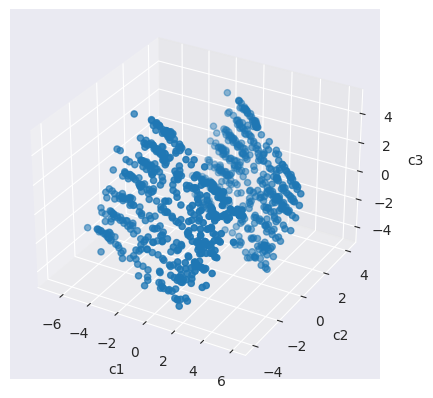

In [130]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def visualize_3d(dataframe, components):
    assert len(components) == 3
    ax = plt.axes(projection='3d')
    
    x_data = dataframe[components[0]].values
    y_data = dataframe[components[1]].values
    z_data = dataframe[components[2]].values

    #using the scatter3D() method by passing 3 co-ordinates 
    ax.scatter3D(x_data, y_data, z_data)
    ax.set_xlabel(components[0])
    ax.set_ylabel(components[1])
    ax.set_zlabel(components[2])
    plt.show()
    
visualize_3d(df_poly_red, cs)

The 3d visualization puts forth the different relations between the components. There is no much room for interpretation as the original features were unknown and the generated components are pretty much built upon mathematical techniques.  
It might be more productive to consider different 2D visualizations

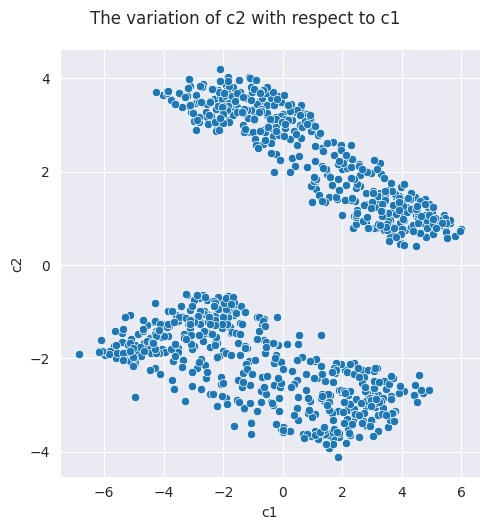

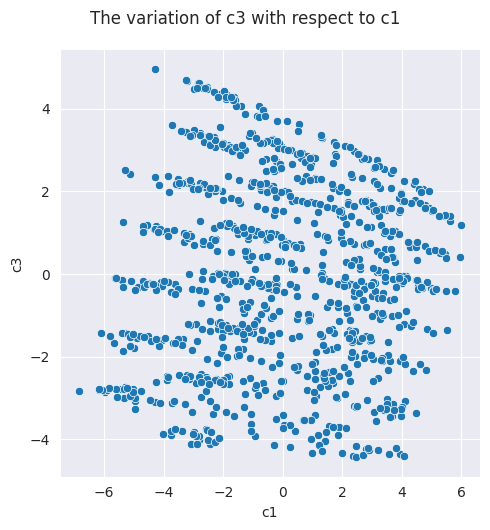

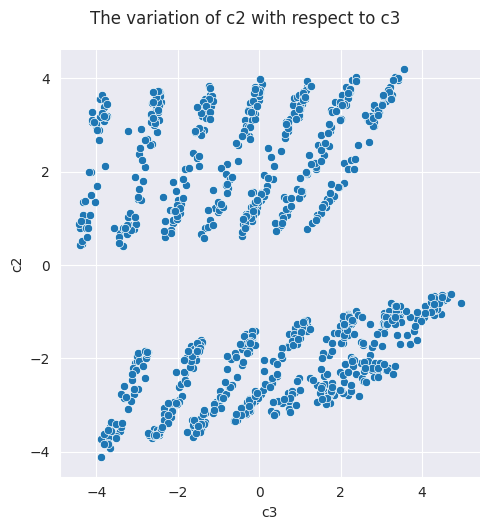

In [131]:
def visualize_2d(dataframe, col1, col2):
    g = sns.relplot(data=dataframe, x=col1, y=col2)
    g.fig.suptitle(t=f'The variation of {col2} with respect to {col1}', y='1.05')
    g.set(xlabel=col1, ylabel=col2)
    plt.show()


visualize_2d(df_poly_red, 'c1', 'c2')
visualize_2d(df_poly_red, 'c1', 'c3')
visualize_2d(df_poly_red, 'c3', 'c2')

In [132]:
print(df)
print(df_org)
print(df.isna().sum())
df_bef_train = df.copy()

         f1       f2      f3          f4      f5  month   f6
0    509.18  417.681  112.00  138.000000  393.00      7  0.0
1    446.06  666.182   97.50   81.000000  352.05      4  1.0
2    235.50  398.097   90.00   90.000000  339.00      3  0.0
3    306.02  518.163  120.75  102.000000  439.25      3  1.0
4    453.08  600.156   99.00  105.000000  422.95      3  0.0
..      ...      ...     ...         ...     ...    ...  ...
920  422.34  547.259  108.00   99.357917  350.45      1  1.0
921  342.62  473.919  105.00  108.592841  200.85      2  0.0
922  265.10  538.170  105.00  107.952339  208.35      6  1.0
923  397.12  622.386  112.00  108.289955  433.45      5  1.0
924  242.10  420.429  102.00  102.049336  369.20      6  1.0

[925 rows x 7 columns]
     target    var1     var2          var3   var4    var5 var6  \
0         0  509.18  417.681    Micronesia  138.0  393.00   no   
1         0  446.06  666.182      Dominica   81.0  352.05  yes   
2         1  235.50  398.097   Isle of Man   9

# Training
It is time to solve the initial problem: predicting the class of the given examples. I will use the following models:
* K-Nearest-Neighbors Classifier
* Naive-Bayes
* Logistic Regression

## Encoding f3: the area column
As the target encoding produced the best results in the first sub problem, using the same encoding for the final problem is a reasonable course of action. The technique is the same, however, the target changed. Thus the encoding values will change as well.

In [133]:
# before proceeding with splitting the data, it is necessary to restore the orginal values of f3

df['f3'] = df_bef_enc['f3'].values
# let's first split the data into training and testing.
df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [134]:
df_train['y'] = y.copy()

target_by_area = pd.pivot_table(df_train, index='f3', values='y', aggfunc=['count', 'mean']).sort_values(by=[('mean','y'), ('count', 'y')], ascending=[False, False])
print(target_by_area)
print(target_by_area.isna().sum())

df_train.drop('y', axis=1, inplace=True)
def encode_area_target(row):
    area = row['f3']
    if area in target_by_area.index.values:
        row['f3'] =  target_by_area[('mean', 'y')][area] * target_by_area[('count', 'y')][area] 
    else:
        row['f3'] = 0.5 # the data is encountered for the first time, its expected value is 0.5
    return row

# encode the area column    
df_train = df_train.apply(encode_area_target, axis=1)
df_test = df_test.apply(encode_area_target, axis=1)


                                             count mean
                                                 y    y
f3                                                     
Ethiopia                                         4  1.0
Hungary                                          4  1.0
Mayotte                                          4  1.0
Uganda                                           4  1.0
Cote d'Ivoire                                    3  1.0
...                                            ...  ...
South Georgia and the South Sandwich Islands     1  0.0
Sudan                                            1  0.0
Suriname                                         1  0.0
Tanzania                                         1  0.0
Uzbekistan                                       1  0.0

[233 rows x 2 columns]
count  y    0
mean   y    0
dtype: int64


In [135]:
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

metrics = [accuracy_score, recall_score, precision_score, f1_score]
metrics_names = ['accuracy', 'recall', 'precision', 'f1']

metrics_dict = dict(zip(metrics, metrics_names))
def Naive_Bayes(df, df_t, y, y_test):
    clf = gnb()
    clf.fit(df.values, y)
    y_p = clf.predict(df_t.values)
    for m, m_name in metrics_dict.items():
        print(f"Naive bayes achieved {m(y_p, y_test)} for {m_name}")
                
    return clf

In [136]:
from sklearn.neighbors import KNeighborsClassifier as KNNC

def KNN(df, df_t, y, y_t):
    knn = KNNC()    
    knn_params = {"n_neighbors": list(range(1, 15)), "weights":['uniform', 'distance']}

    knn_searcher = GridSearchCV(knn, knn_params, scoring='accuracy', cv=CV)
    
    knn_searcher.fit(df.values, y)

    knn_est = knn_searcher.best_estimator_
    
    y_p = knn_est.predict(df_t.values)
    for m, m_name in metrics_dict.items():
        print(f"KNN achieved {m(y_p, y_test)} for {m_name}")
    
    return knn_est


In [137]:
from sklearn.linear_model import LogisticRegression as LR

def LogReg(df, df_t, y, y_t):
    lr = LR(max_iter=5000)    
    lr_params = {"penalty": ['l2'], 'C': [10 ** i for i in range(-3, 4)]}
    lr_searcher = GridSearchCV(lr, lr_params, scoring='accuracy', cv=CV)
    
    lr_searcher.fit(df.values, y)

    lr_est = lr_searcher.best_estimator_
    
    y_p = lr_est.predict(df_t.values)
    print()
    for m, m_name in metrics_dict.items():
        print(f"Logistic Regression achieved {m(y_p, y_test)} for {m_name}")

    print()
    return lr_est


In [138]:
functions = [Naive_Bayes, LogReg, KNN]
# making sure the target variable is not included in the training or test dataset
print(df_train.columns)
print(df_test.columns) 
for f in functions:
    f(df_train, df_test, y_train, y_test)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'month', 'f6'], dtype='object')
Index(['f1', 'f2', 'f3', 'f4', 'f5', 'month', 'f6'], dtype='object')
Naive bayes achieved 0.9351351351351351 for accuracy
Naive bayes achieved 0.9347826086956522 for recall
Naive bayes achieved 0.9347826086956522 for precision
Naive bayes achieved 0.9347826086956522 for f1

Logistic Regression achieved 0.9297297297297298 for accuracy
Logistic Regression achieved 0.9247311827956989 for recall
Logistic Regression achieved 0.9347826086956522 for precision
Logistic Regression achieved 0.9297297297297297 for f1

KNN achieved 0.9459459459459459 for accuracy
KNN achieved 0.9555555555555556 for recall
KNN achieved 0.9347826086956522 for precision
KNN achieved 0.945054945054945 for f1


## Applying PCA to the dataset
In this section, I apply PCA one the preprocessed, imputed dataset to inspect the effect of dimensionality reduction on the performance.

In [139]:
# the data originally has 7 features
from sklearn.decomposition import PCA

def red_to_n_comps(df_train, df_test, y_train, y_test, n):
    red_scaler = StandardScaler()
    X_train_s = red_scaler.fit_transform(df_train)
    X_test_s = red_scaler.transform(df_test)
 
    X_red_train, U_red = custom_PCA(X_train_s, d=n)
    
    X_red_test = X_test_s @ U_red
    X_red_train = pd.DataFrame(X_red_train)
    X_red_test = pd.DataFrame(X_red_test)
    
    for f in functions:
        f(X_red_train, X_red_test, y_train, y_test)
    
def best_red_dim(df_train, df_test, y_train, y_test):
    for i in range(1, 5):
        print({f"The results of reducing the data to {str(i)} dimension{'' if i == 1 else 's'}" })
        print()
        red_to_n_comps(df_train, df_test, y_train, y_test, i)
        print()
        
best_red_dim(df_train, df_test, y_train, y_test)

{'The results of reducing the data to 1 dimension'}

Naive bayes achieved 0.9243243243243243 for accuracy
Naive bayes achieved 0.9642857142857143 for recall
Naive bayes achieved 0.8804347826086957 for precision
Naive bayes achieved 0.9204545454545455 for f1

Logistic Regression achieved 0.9243243243243243 for accuracy
Logistic Regression achieved 0.9642857142857143 for recall
Logistic Regression achieved 0.8804347826086957 for precision
Logistic Regression achieved 0.9204545454545455 for f1

KNN achieved 0.9243243243243243 for accuracy
KNN achieved 0.9431818181818182 for recall
KNN achieved 0.9021739130434783 for precision
KNN achieved 0.9222222222222224 for f1

{'The results of reducing the data to 2 dimensions'}

Naive bayes achieved 0.918918918918919 for accuracy
Naive bayes achieved 0.9529411764705882 for recall
Naive bayes achieved 0.8804347826086957 for precision
Naive bayes achieved 0.9152542372881357 for f1

Logistic Regression achieved 0.9135135135135135 for accuracy
Logistic 

In [140]:
# this cell was created to demonstrate the correctness of the 
# custom implementation. The errors are very small.
s = StandardScaler()
df_train_s = s.fit_transform(df_train)
# df_test_r = s.transform(df_test)
df_train_r, U_red = custom_PCA(df_train_s, d=3)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
df_train_pca = pca.fit_transform(df_train_s)
print(df_train_pca - df_train_r)

[[-7.10542736e-15  2.64226509e+00  2.73392420e-14]
 [-3.10862447e-15  1.68602556e-01 -3.10862447e-15]
 [-1.77635684e-15 -8.14585353e-01 -5.66213743e-15]
 ...
 [ 1.77635684e-15 -2.86738751e+00 -3.56381591e-14]
 [ 1.55431223e-15 -1.71298051e+00 -1.64313008e-14]
 [-1.22124533e-15  2.21701839e+00  1.98729921e-14]]


# Theory-related part
In this subsection, I perform different visualizations and computations to support my explanations in the report.


## f4 intercation with the rest of the columns
In this part I demonstrate the non-linearity of the interactions between f4 and the rest of the features. 

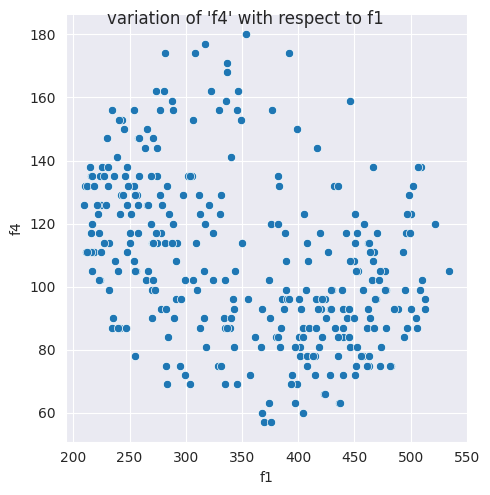

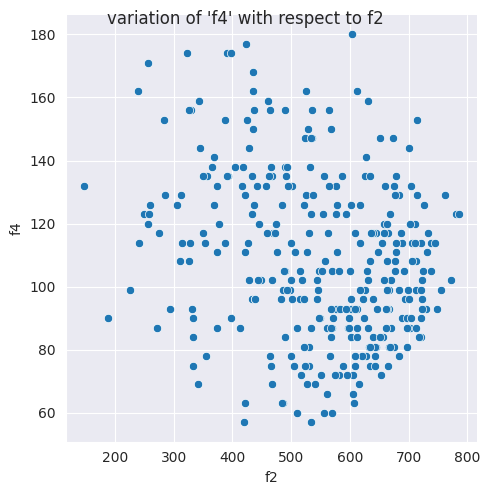

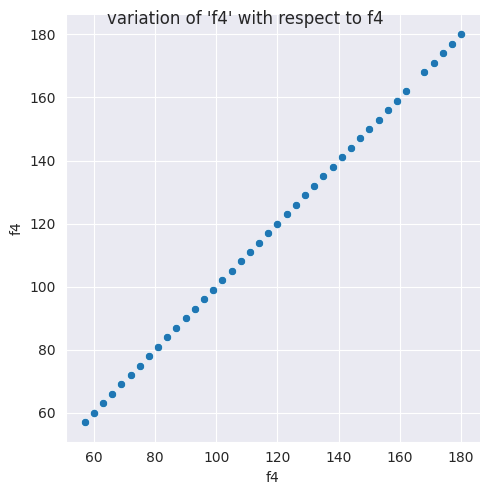

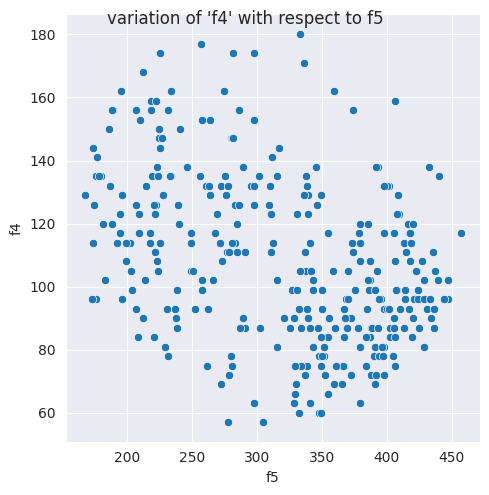

In [141]:
# first let's upload the dataframe before imputing the missing values: f3 encoded with target encoding
df = df_bef_imp.copy() 

df_4 = df[~df['f4'].isna()] 

num_cols, cat_cols = num_cat(df_4)

for col in num_cols[:-2]: # f6 and f7 are encoded already
    g = sns.relplot(kind='scatter', data=df_4, x=col, y='f4')
    g.fig.suptitle(f"variation of 'f4' with respect to {col}")
    g.set(xlabel=col, ylabel='f4')
    plt.show()

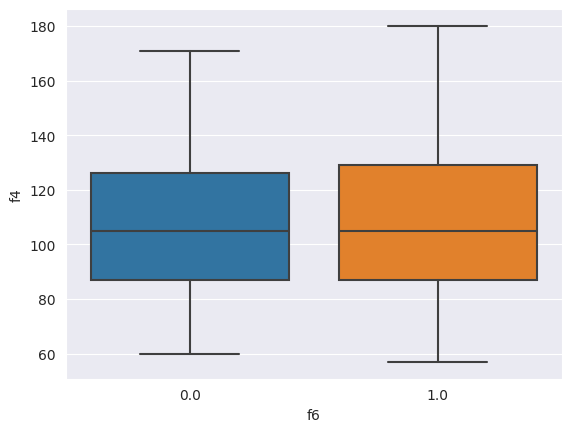

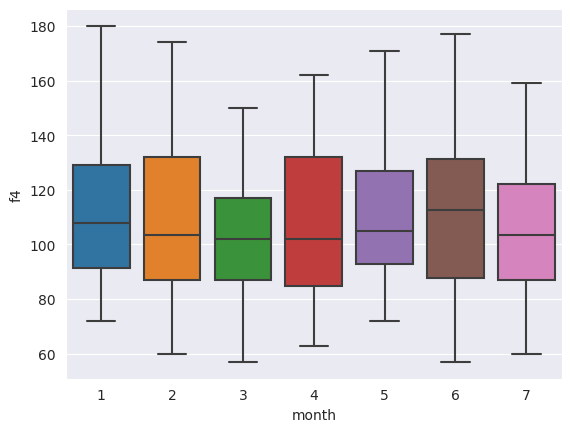

In [142]:
# let's investigate the effect of categorical features 
sns.boxplot(data=df_4, y='f4', x='f6')
plt.show()
sns.boxplot(data=df_4, y='f4', x=month)
plt.show()

## the target variable's  intercation with the rest of features 

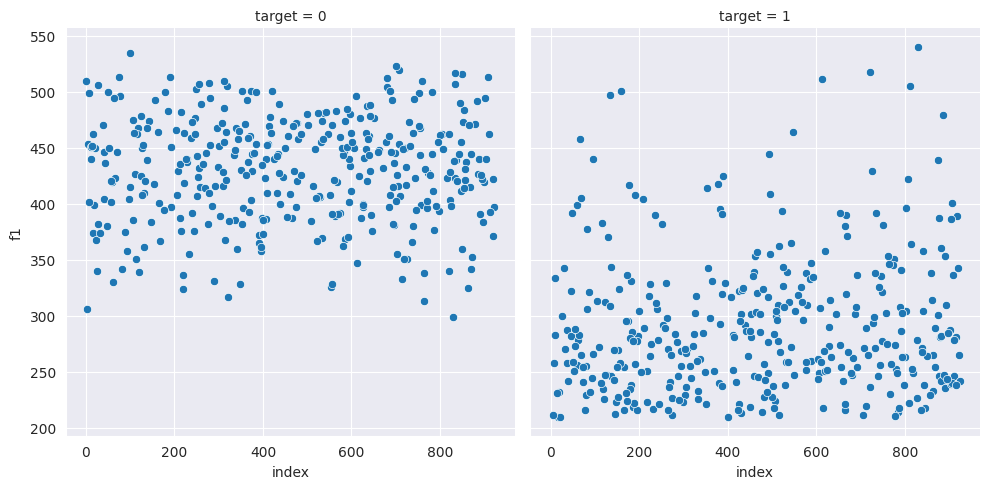

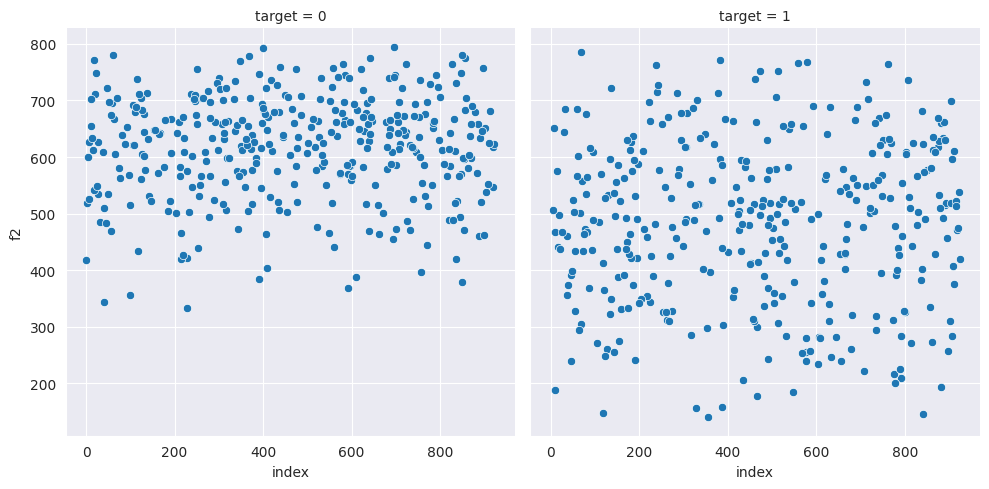

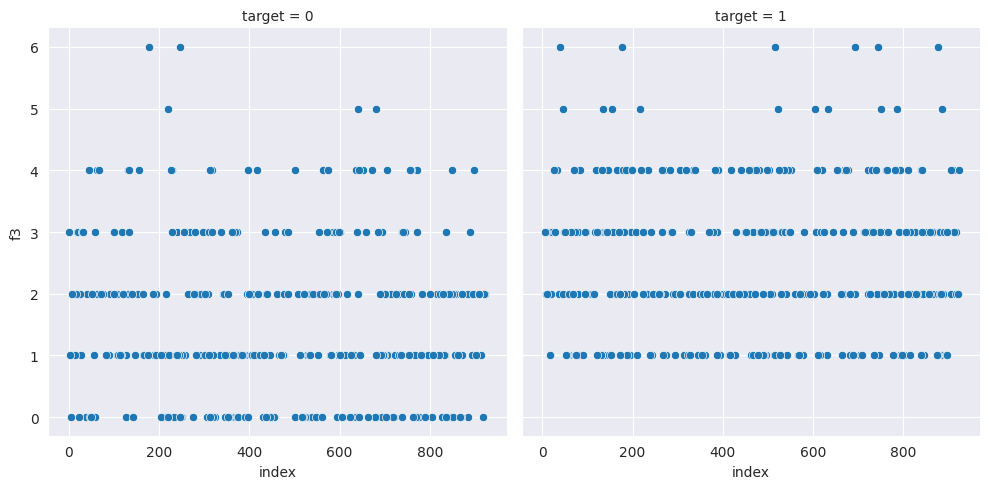

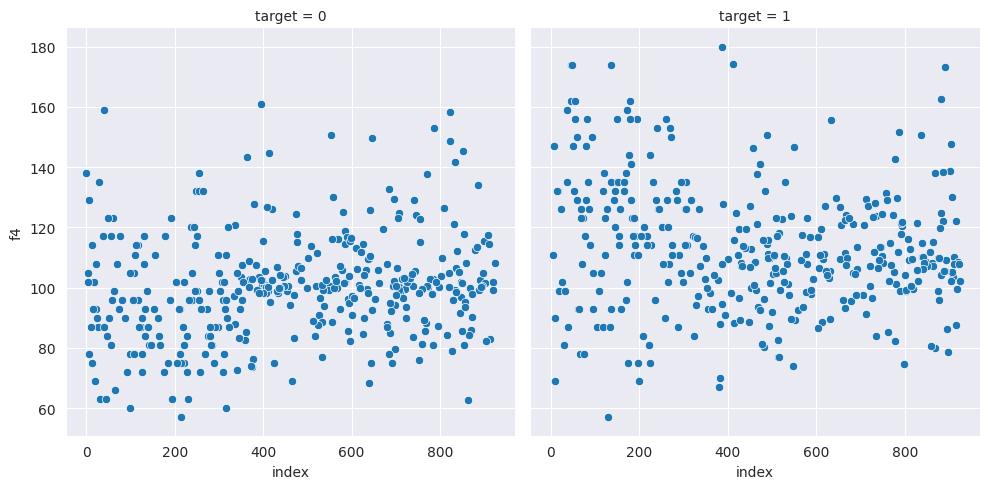

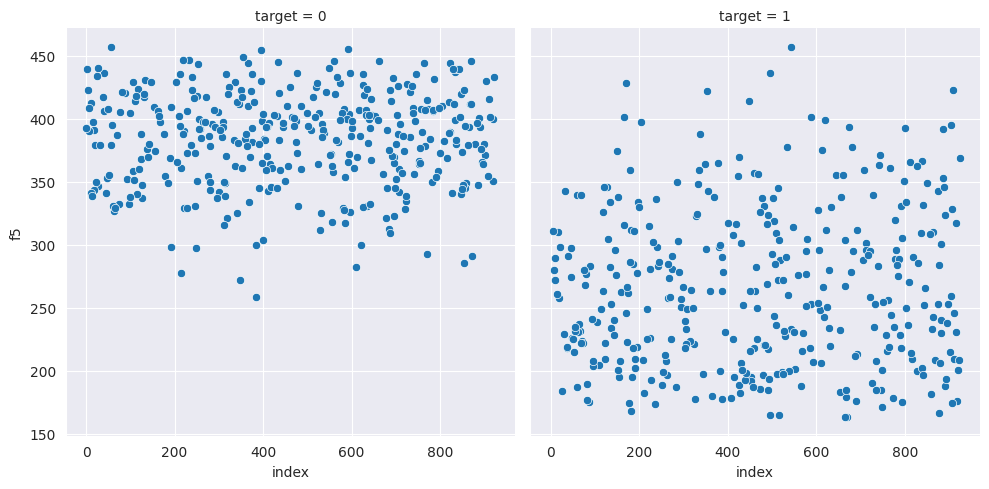

In [143]:
# the data considered here should be the training data used for the final classification

df = df_train.copy()
# let's start with data visualizations

num_cols, cat_cols = num_cat(df)

# this method is short for first impression numerical, where I consider the variation of certain numerical features on each class
def first_imp_num(df, y, col_name):
    df_c = df.dropna(axis=1).copy() # a copy with non Nan values
    f1_fig = sns.relplot(data=df, x=df_c.index.values, y=col_name, col=y, col_order=[0, 1])
    f1_fig.set(xlabel="index", ylabel=col_name)
    plt.show()

for col in num_cols[:-2]:
    first_imp_num(df, y_train, col)

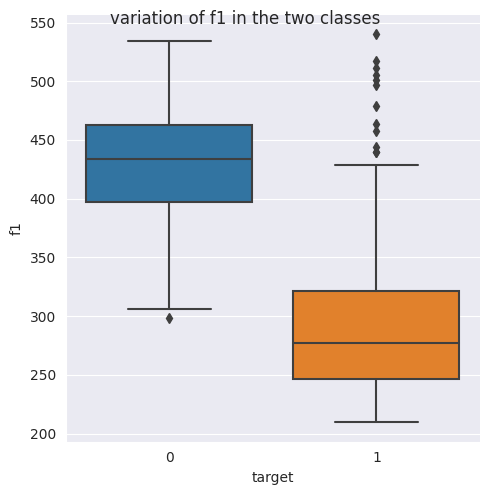

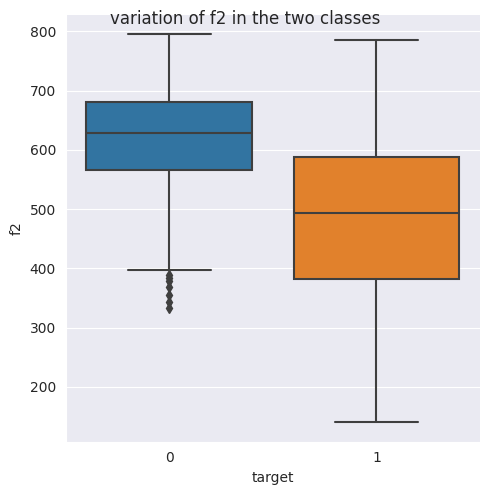

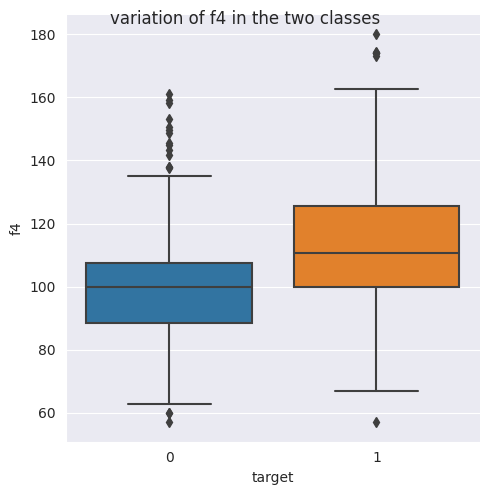

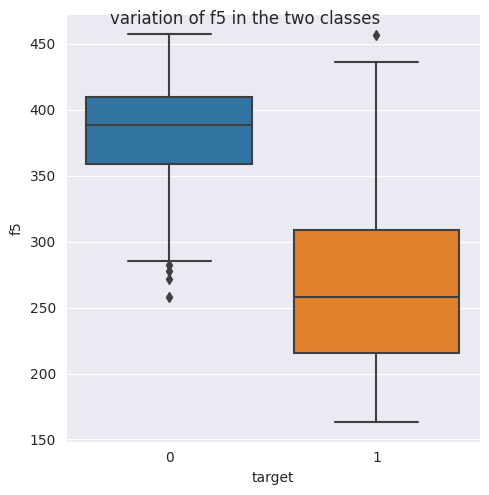

In [144]:
# let's put forth this correlation even more clearly using box plots

df['y'] = y_train.copy()
for col in ['f1', 'f2', 'f4', 'f5']: # f6 and f7 are encoded already
    g = sns.catplot(kind='box', data=df, x='y', y=col)
    g.fig.suptitle(f"variation of {col} in the two classes")
    g.set(xlabel='target', ylabel=col)
    plt.show()

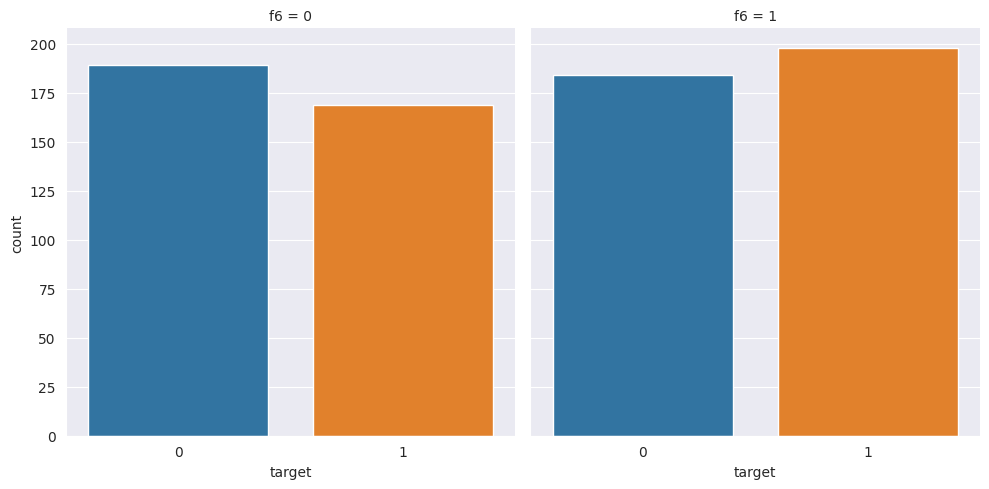

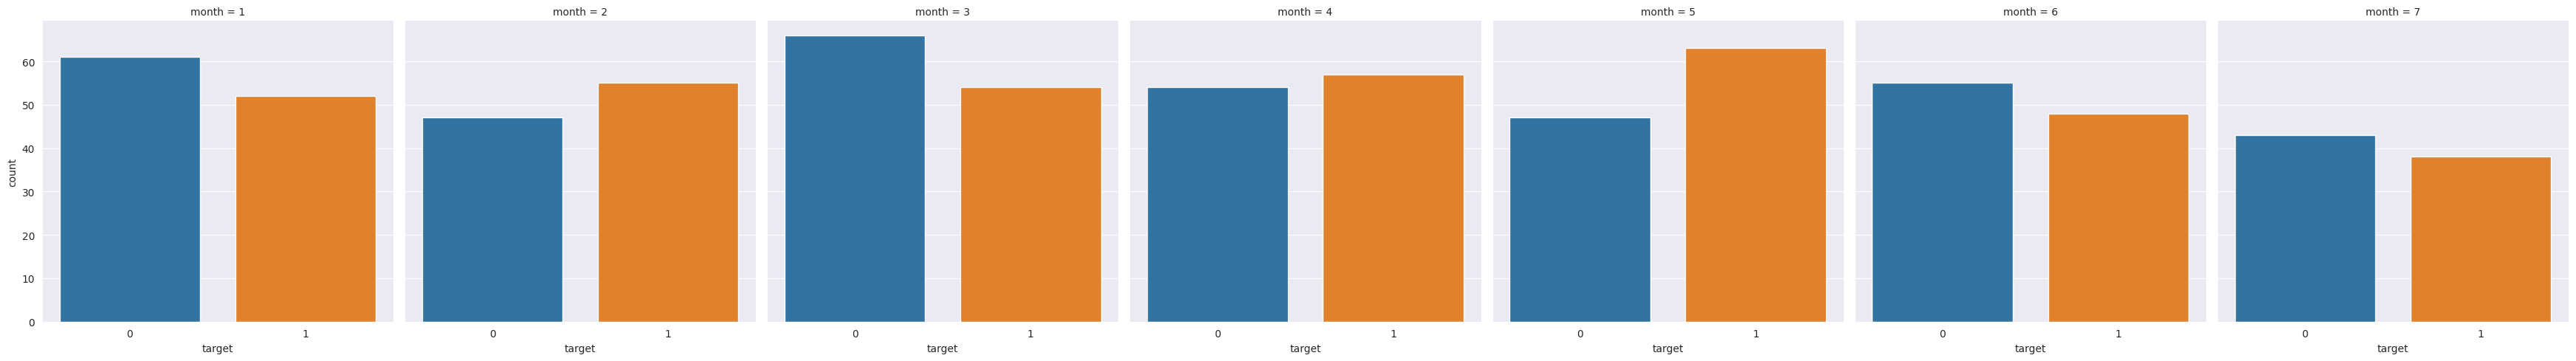

In [145]:
# displaying the variation of
g = sns.catplot(kind='count', ci=None, data=df, x='y', col='f6', col_order=[0, 1])
g.set(xlabel='target')
plt.show()

g = sns.catplot(kind='count', ci=None, data=df, x='y', col=month, col_order=np.unique(df[month]))
g.set(xlabel='target')
plt.show()


These data visualizations suggest that the numerical can be grouped in accordance to their correlation with the target variable
1. f1, f5: very relevant
2. f4, f2: moderately relevant
3. f6, f7(month): little to no relevance

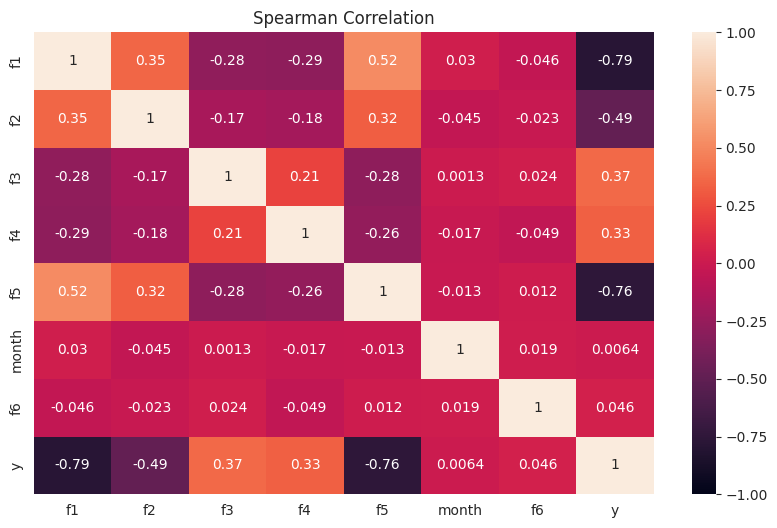

In [146]:
# let's back up the visualization with correlation calculations

r = df.corr(method="spearman")
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df.corr(), vmin=-1, 
                    vmax=1, annot=True)
plt.title("Spearman Correlation")
plt.show()

In [147]:
df_train_exp = df_train.drop('f6', axis=1)
df_train_exp = df_train_exp.drop('month', axis=1)

df_test_exp = df_test.drop('f6', axis=1)
df_test_exp = df_test_exp.drop('month', axis=1)
print(df_test_exp.columns)

ests = [f(df_train_exp, df_test_exp, y_train, y_test) for f in functions] 


Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Naive bayes achieved 0.9351351351351351 for accuracy
Naive bayes achieved 0.9347826086956522 for recall
Naive bayes achieved 0.9347826086956522 for precision
Naive bayes achieved 0.9347826086956522 for f1

Logistic Regression achieved 0.9297297297297298 for accuracy
Logistic Regression achieved 0.9247311827956989 for recall
Logistic Regression achieved 0.9347826086956522 for precision
Logistic Regression achieved 0.9297297297297297 for f1

KNN achieved 0.9513513513513514 for accuracy
KNN achieved 0.9560439560439561 for recall
KNN achieved 0.9456521739130435 for precision
KNN achieved 0.9508196721311475 for f1
